Generating all visualizations...
1. F1-Score plot...


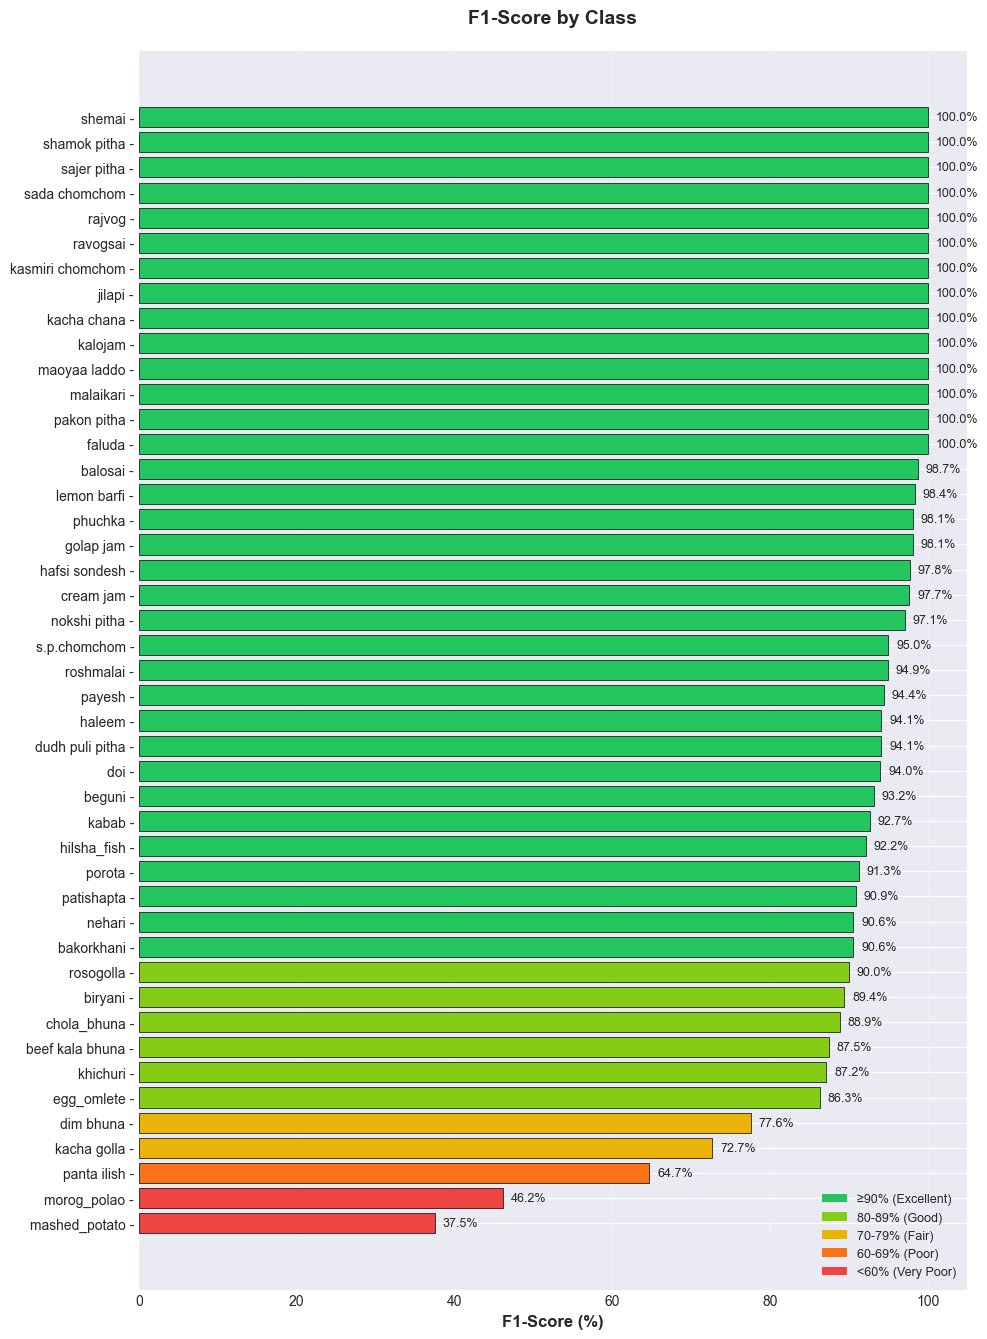

2. Metrics comparison...


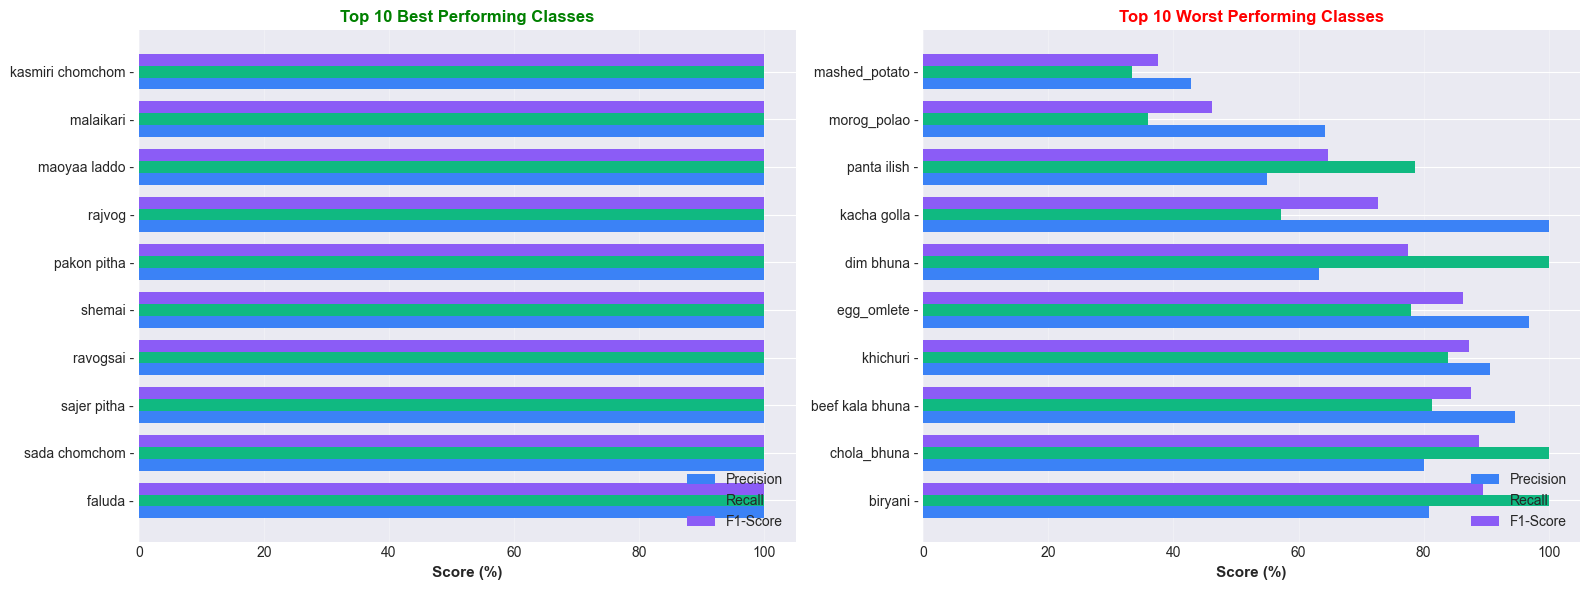

3. Top confusions...


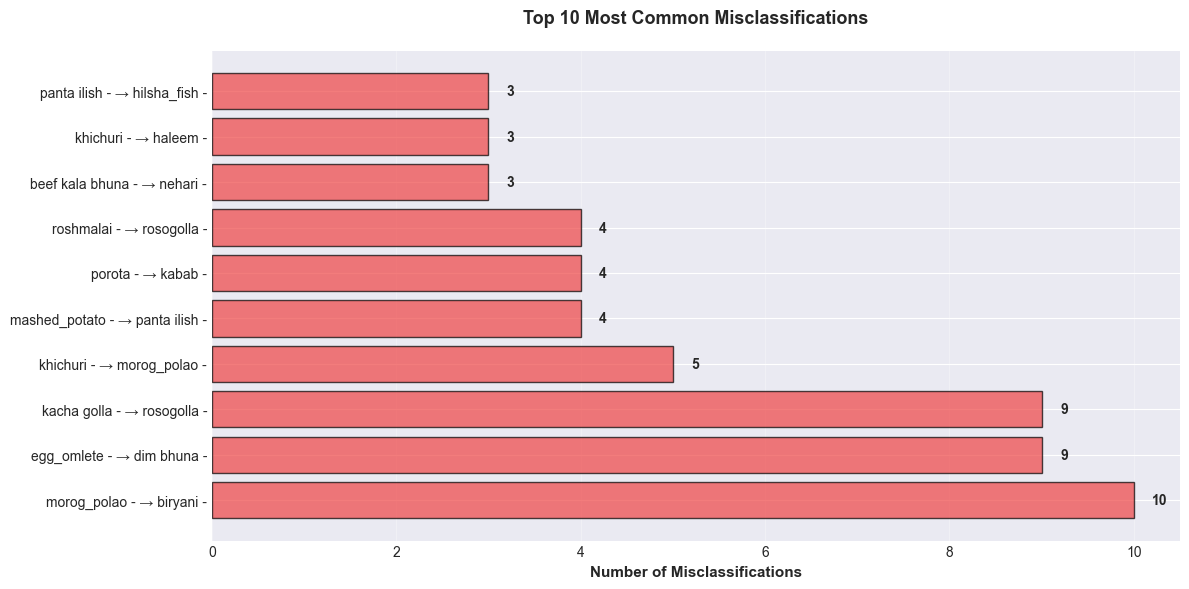

4. Classification report table...


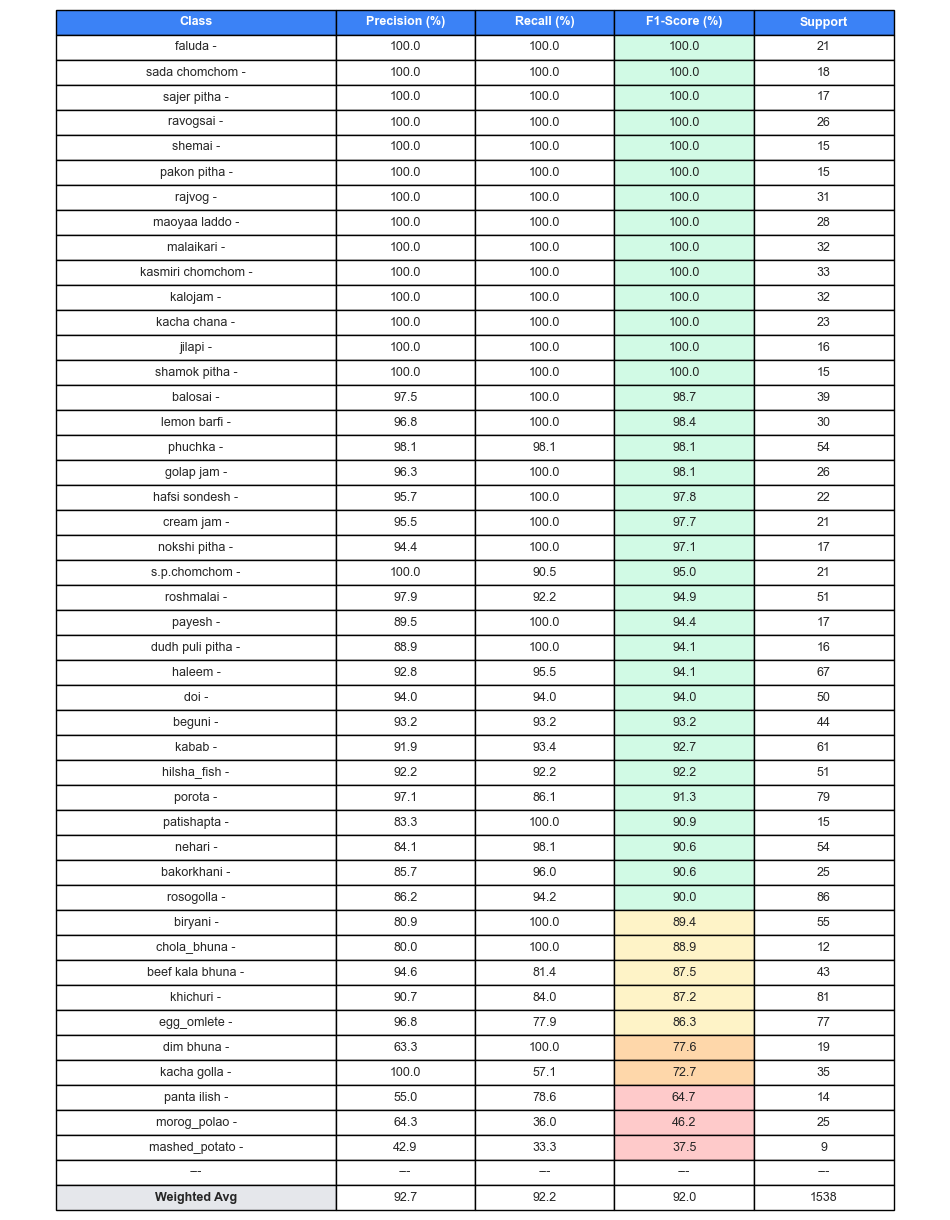

5. Performance heatmap...


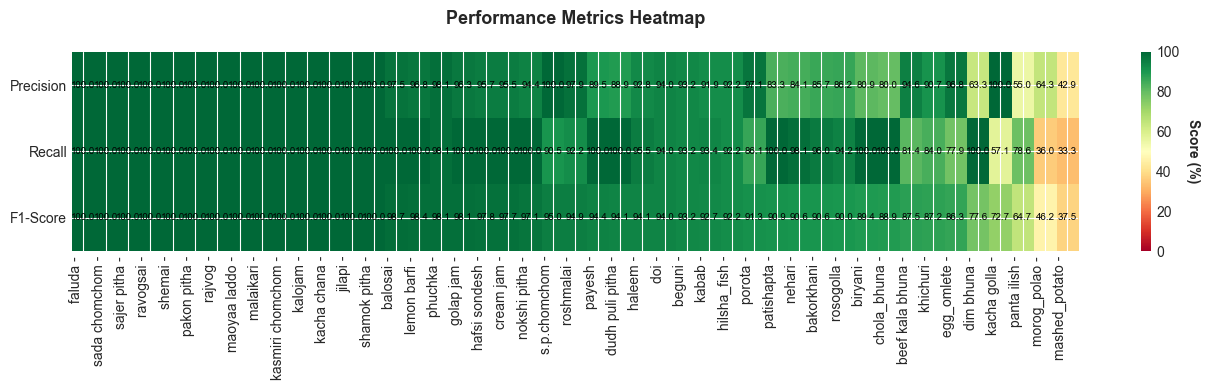

6. Per-class accuracy...


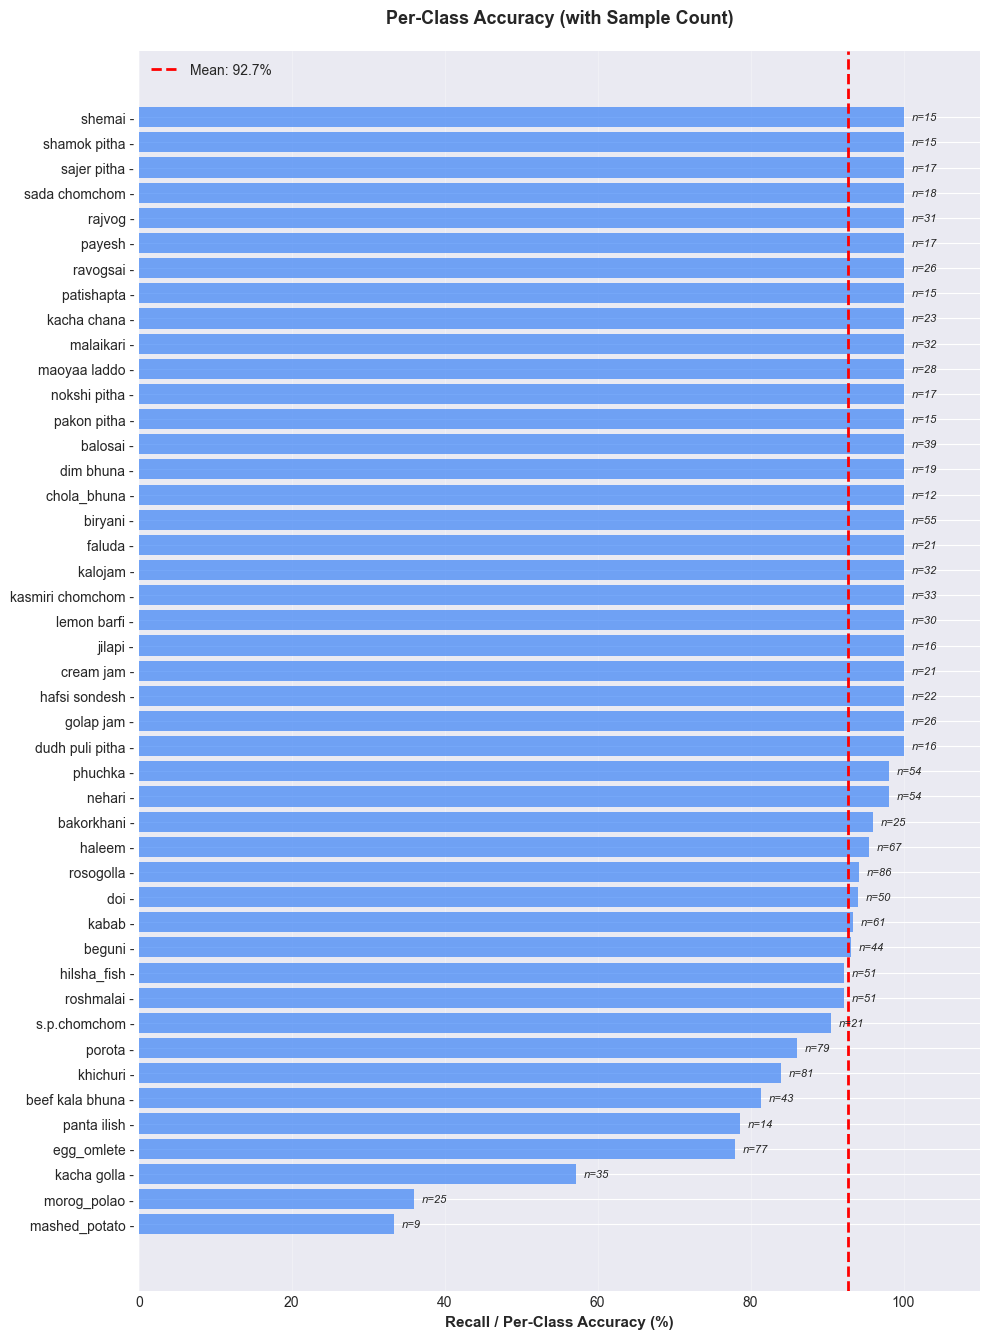


All plots saved to ./plots_Fewshot/
Metrics saved to ./plots_Fewshot/classification_metrics.csv


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
from matplotlib.patches import Rectangle

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

class ConfusionMatrixVisualizer:
    """
    Reusable class for creating publication-ready visualizations from confusion matrices.
    """
    
    def __init__(self, cm, class_names, figsize=(12, 8)):
        """
        Initialize the visualizer.
        
        Parameters:
        -----------
        cm : array-like, shape (n_classes, n_classes)
            Confusion matrix
        class_names : list
            List of class names
        figsize : tuple
            Default figure size
        """
        self.cm = np.array(cm)
        self.class_names = class_names
        self.n_classes = len(class_names)
        self.figsize = figsize
        self.metrics = self._calculate_metrics()
        
    def _calculate_metrics(self):
        """Calculate precision, recall, F1-score for each class."""
        metrics = []
        
        for i in range(self.n_classes):
            tp = self.cm[i, i]
            fp = self.cm[:, i].sum() - tp
            fn = self.cm[i, :].sum() - tp
            tn = self.cm.sum() - tp - fp - fn
            
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
            support = self.cm[i, :].sum()
            
            metrics.append({
                'class': self.class_names[i],
                'precision': precision * 100,
                'recall': recall * 100,
                'f1': f1 * 100,
                'support': int(support),
                'tp': int(tp),
                'fp': int(fp),
                'fn': int(fn)
            })
        
        return pd.DataFrame(metrics)
    
    def plot_f1_scores(self, save_path=None, top_n=None, sort=True):
        """
        Plot F1-scores for all classes as horizontal bars.
        
        Parameters:
        -----------
        save_path : str, optional
            Path to save the figure
        top_n : int, optional
            Show only top N and bottom N classes
        sort : bool
            Whether to sort by F1-score
        """
        df = self.metrics.copy()
        if sort:
            df = df.sort_values('f1', ascending=True)
        
        if top_n:
            df = pd.concat([df.head(top_n), df.tail(top_n)])
        
        # Color coding based on F1-score
        colors = []
        for f1 in df['f1']:
            if f1 >= 90:
                colors.append('#22c55e')  # Green
            elif f1 >= 80:
                colors.append('#84cc16')  # Lime
            elif f1 >= 70:
                colors.append('#eab308')  # Yellow
            elif f1 >= 60:
                colors.append('#f97316')  # Orange
            else:
                colors.append('#ef4444')  # Red
        
        fig, ax = plt.subplots(figsize=(10, max(8, len(df) * 0.3)))
        bars = ax.barh(df['class'], df['f1'], color=colors, edgecolor='black', linewidth=0.5)
        
        ax.set_xlabel('F1-Score (%)', fontsize=12, fontweight='bold')
        ax.set_title('F1-Score by Class', fontsize=14, fontweight='bold', pad=20)
        ax.set_xlim(0, 105)
        ax.grid(axis='x', alpha=0.3)
        
        # Add value labels on bars
        for i, (bar, f1) in enumerate(zip(bars, df['f1'])):
            ax.text(f1 + 1, bar.get_y() + bar.get_height()/2, 
                   f'{f1:.1f}%', va='center', fontsize=9)
        
        # Add legend
        legend_elements = [
            Rectangle((0,0),1,1, facecolor='#22c55e', label='≥90% (Excellent)'),
            Rectangle((0,0),1,1, facecolor='#84cc16', label='80-89% (Good)'),
            Rectangle((0,0),1,1, facecolor='#eab308', label='70-79% (Fair)'),
            Rectangle((0,0),1,1, facecolor='#f97316', label='60-69% (Poor)'),
            Rectangle((0,0),1,1, facecolor='#ef4444', label='<60% (Very Poor)')
        ]
        ax.legend(handles=legend_elements, loc='lower right', fontsize=9)
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
    
    def plot_metrics_comparison(self, save_path=None, top_n=10):
        """
        Plot precision, recall, and F1-score comparison for best and worst classes.
        
        Parameters:
        -----------
        save_path : str, optional
            Path to save the figure
        top_n : int
            Number of top and bottom classes to show
        """
        df_sorted = self.metrics.sort_values('f1', ascending=False)
        top_classes = df_sorted.head(top_n)
        bottom_classes = df_sorted.tail(top_n)
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        # Top performers
        x = np.arange(len(top_classes))
        width = 0.25
        
        ax1.barh(x - width, top_classes['precision'], width, label='Precision', color='#3b82f6')
        ax1.barh(x, top_classes['recall'], width, label='Recall', color='#10b981')
        ax1.barh(x + width, top_classes['f1'], width, label='F1-Score', color='#8b5cf6')
        
        ax1.set_yticks(x)
        ax1.set_yticklabels(top_classes['class'])
        ax1.set_xlabel('Score (%)', fontsize=11, fontweight='bold')
        ax1.set_title(f'Top {top_n} Best Performing Classes', fontsize=12, fontweight='bold', color='green')
        ax1.legend(loc='lower right')
        ax1.set_xlim(0, 105)
        ax1.grid(axis='x', alpha=0.3)
        
        # Bottom performers
        x = np.arange(len(bottom_classes))
        
        ax2.barh(x - width, bottom_classes['precision'], width, label='Precision', color='#3b82f6')
        ax2.barh(x, bottom_classes['recall'], width, label='Recall', color='#10b981')
        ax2.barh(x + width, bottom_classes['f1'], width, label='F1-Score', color='#8b5cf6')
        
        ax2.set_yticks(x)
        ax2.set_yticklabels(bottom_classes['class'])
        ax2.set_xlabel('Score (%)', fontsize=11, fontweight='bold')
        ax2.set_title(f'Top {top_n} Worst Performing Classes', fontsize=12, fontweight='bold', color='red')
        ax2.legend(loc='lower right')
        ax2.set_xlim(0, 105)
        ax2.grid(axis='x', alpha=0.3)
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
    
    def plot_top_confusions(self, save_path=None, top_n=10, min_count=1):
        """
        Plot the most common misclassifications.
        
        Parameters:
        -----------
        save_path : str, optional
            Path to save the figure
        top_n : int
            Number of top confusions to show
        min_count : int
            Minimum number of misclassifications to include
        """
        # Find all misclassifications
        confusions = []
        for i in range(self.n_classes):
            for j in range(self.n_classes):
                if i != j and self.cm[i, j] > min_count:
                    confusions.append({
                        'true': self.class_names[i],
                        'pred': self.class_names[j],
                        'count': int(self.cm[i, j])
                    })
        
        # Sort by count
        confusions = sorted(confusions, key=lambda x: x['count'], reverse=True)[:top_n]
        
        if not confusions:
            print("No significant confusions found!")
            return
        
        fig, ax = plt.subplots(figsize=(12, max(6, len(confusions) * 0.4)))
        
        y_pos = np.arange(len(confusions))
        counts = [c['count'] for c in confusions]
        labels = [f"{c['true']} → {c['pred']}" for c in confusions]
        
        bars = ax.barh(y_pos, counts, color='#ef4444', alpha=0.7, edgecolor='black')
        
        ax.set_yticks(y_pos)
        ax.set_yticklabels(labels, fontsize=10)
        ax.set_xlabel('Number of Misclassifications', fontsize=11, fontweight='bold')
        ax.set_title(f'Top {len(confusions)} Most Common Misclassifications', 
                    fontsize=13, fontweight='bold', pad=20)
        ax.grid(axis='x', alpha=0.3)
        
        # Add count labels
        for bar, count in zip(bars, counts):
            ax.text(count + 0.2, bar.get_y() + bar.get_height()/2, 
                   str(count), va='center', fontweight='bold')
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
        
        return confusions
    
    def plot_classification_report_table(self, save_path=None):
        """
        Create a clean table with classification metrics.
        
        Parameters:
        -----------
        save_path : str, optional
            Path to save the figure
        """
        df = self.metrics.sort_values('f1', ascending=False)
        
        fig, ax = plt.subplots(figsize=(12, max(8, len(df) * 0.25)))
        ax.axis('tight')
        ax.axis('off')
        
        # Prepare data for table
        table_data = []
        for _, row in df.iterrows():
            table_data.append([
                row['class'],
                f"{row['precision']:.1f}",
                f"{row['recall']:.1f}",
                f"{row['f1']:.1f}",
                f"{row['support']}"
            ])
        
        # Add summary row
        avg_precision = (df['precision'] * df['support']).sum() / df['support'].sum()
        avg_recall = (df['recall'] * df['support']).sum() / df['support'].sum()
        avg_f1 = (df['f1'] * df['support']).sum() / df['support'].sum()
        total_support = df['support'].sum()
        
        table_data.append(['---', '---', '---', '---', '---'])
        table_data.append([
            'Weighted Avg',
            f"{avg_precision:.1f}",
            f"{avg_recall:.1f}",
            f"{avg_f1:.1f}",
            f"{total_support}"
        ])
        
        # Create table
        table = ax.table(cellText=table_data,
                        colLabels=['Class', 'Precision (%)', 'Recall (%)', 'F1-Score (%)', 'Support'],
                        cellLoc='center',
                        loc='center',
                        colWidths=[0.3, 0.15, 0.15, 0.15, 0.15])
        
        table.auto_set_font_size(False)
        table.set_fontsize(9)
        table.scale(1, 1.5)
        
        # Style header
        for i in range(5):
            table[(0, i)].set_facecolor('#3b82f6')
            table[(0, i)].set_text_props(weight='bold', color='white')
        
        # Color code F1-scores
        for i in range(1, len(table_data) - 1):  # Skip header and summary rows
            f1_val = float(table_data[i-1][3])
            if f1_val >= 90:
                color = '#d1fae5'
            elif f1_val >= 80:
                color = '#fef3c7'
            elif f1_val >= 70:
                color = '#fed7aa'
            else:
                color = '#fecaca'
            table[(i, 3)].set_facecolor(color)
        
        # Style summary row
        table[(len(table_data), 0)].set_facecolor('#e5e7eb')
        table[(len(table_data), 0)].set_text_props(weight='bold')
        
        #plt.title('Complete Classification Report', fontsize=14, fontweight='bold', pad=20)
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
    
    def plot_performance_heatmap(self, save_path=None):
        """
        Create a heatmap showing precision, recall, and F1-score for each class.
        
        Parameters:
        -----------
        save_path : str, optional
            Path to save the figure
        """
        df = self.metrics.sort_values('f1', ascending=False)
        
        # Prepare data for heatmap
        heatmap_data = df[['precision', 'recall', 'f1']].values.T
        
        fig, ax = plt.subplots(figsize=(max(12, len(df) * 0.3), 4))
        
        im = ax.imshow(heatmap_data, cmap='RdYlGn', aspect='auto', vmin=0, vmax=100)
        
        # Set ticks
        ax.set_xticks(np.arange(len(df)))
        ax.set_yticks(np.arange(3))
        ax.set_xticklabels(df['class'], rotation=90, ha='right')
        ax.set_yticklabels(['Precision', 'Recall', 'F1-Score'])
        
        # Add colorbar
        cbar = plt.colorbar(im, ax=ax)
        cbar.set_label('Score (%)', rotation=270, labelpad=15, fontweight='bold')
        
        # Add text annotations
        for i in range(3):
            for j in range(len(df)):
                text = ax.text(j, i, f'{heatmap_data[i, j]:.1f}',
                             ha="center", va="center", color="black", fontsize=7)
        
        ax.set_title('Performance Metrics Heatmap', fontsize=13, fontweight='bold', pad=20)
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
    
    def plot_per_class_accuracy(self, save_path=None):
        """
        Plot per-class accuracy (recall) with support shown.
        
        Parameters:
        -----------
        save_path : str, optional
            Path to save the figure
        """
        df = self.metrics.sort_values('recall', ascending=True)
        
        fig, ax = plt.subplots(figsize=(10, max(8, len(df) * 0.3)))
        
        bars = ax.barh(df['class'], df['recall'], color='#3b82f6', alpha=0.7)
        
        # Add support as text
        for i, (bar, support) in enumerate(zip(bars, df['support'])):
            ax.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, 
                   f"n={support}", va='center', fontsize=8, style='italic')
        
        ax.set_xlabel('Recall / Per-Class Accuracy (%)', fontsize=11, fontweight='bold')
        ax.set_title('Per-Class Accuracy (with Sample Count)', fontsize=13, fontweight='bold', pad=20)
        ax.set_xlim(0, 110)
        ax.grid(axis='x', alpha=0.3)
        ax.axvline(x=df['recall'].mean(), color='red', linestyle='--', 
                  label=f"Mean: {df['recall'].mean():.1f}%", linewidth=2)
        ax.legend()
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
    
    def generate_all_plots(self, output_dir='./plots/'):
        """
        Generate all visualizations and save them.
        
        Parameters:
        -----------
        output_dir : str
            Directory to save all plots
        """
        import os
        os.makedirs(output_dir, exist_ok=True)
        
        print("Generating all visualizations...")
        
        print("1. F1-Score plot...")
        self.plot_f1_scores(save_path=f'{output_dir}f1_scores.png')
        
        print("2. Metrics comparison...")
        self.plot_metrics_comparison(save_path=f'{output_dir}best_worst_comparison.png')
        
        print("3. Top confusions...")
        self.plot_top_confusions(save_path=f'{output_dir}top_confusions.png')
        
        print("4. Classification report table...")
        self.plot_classification_report_table(save_path=f'{output_dir}classification_report.png')
        
        print("5. Performance heatmap...")
        self.plot_performance_heatmap(save_path=f'{output_dir}performance_heatmap.png')
        
        print("6. Per-class accuracy...")
        self.plot_per_class_accuracy(save_path=f'{output_dir}per_class_accuracy.png')
        
        print(f"\nAll plots saved to {output_dir}")
        
        # Save metrics to CSV
        self.metrics.to_csv(f'{output_dir}classification_metrics.csv', index=False)
        print(f"Metrics saved to {output_dir}classification_metrics.csv")


# =======================
# EXAMPLE USAGE
# =======================

if __name__ == "__main__":
    
    # ========================================
    # CHANGE THIS SECTION FOR YOUR CSV FILE
    # ========================================
    
    import pandas as pd
    
    # OPTION 1: If your CSV has class names as the first column and first row
    # (like the Bangladeshi food data you shared)
    df = pd.read_csv('Fewshot.csv', index_col=0)
    cm = df.values
    class_names = df.columns.tolist()
    
    # OPTION 2: If your CSV has no headers (just numbers)
    # df = pd.read_csv('your_confusion_matrix.csv', header=None)
    # cm = df.values
    # class_names = ['Class1', 'Class2', 'Class3', ...]  # Manually specify class names
    
    # OPTION 3: If you want to clean the class names (remove extra characters)
    # class_names = [name.strip().replace(' -', '') for name in class_names]
    
    # ========================================
    # CREATE VISUALIZER AND GENERATE PLOTS
    # ========================================
    
    # Create the visualizer
    viz = ConfusionMatrixVisualizer(cm, class_names)
    
    # Generate ALL plots at once and save to a folder
    viz.generate_all_plots(output_dir='./plots_Fewshot/')
    
    # OR generate individual plots (uncomment the ones you want)
    # viz.plot_f1_scores(save_path='f1_scores.png')
    # viz.plot_metrics_comparison(top_n=10, save_path='comparison.png')
    # viz.plot_top_confusions(top_n=10, save_path='confusions.png')
    # viz.plot_classification_report_table(save_path='report.png')
    # viz.plot_performance_heatmap(save_path='heatmap.png')
    # viz.plot_per_class_accuracy(save_path='accuracy.png')
    
    
    # ========================================
    # DEMO EXAMPLE (comment this out when using your own data)
    # ========================================
    
    # For demonstration, here's a small example
    # class_names_demo = ['Pizza', 'Burger', 'Pasta', 'Salad', 'Soup']
    # cm_demo = np.array([
    #     [45, 2, 1, 0, 2],
    #     [1, 48, 0, 1, 0],
    #     [2, 0, 42, 3, 3],
    #     [0, 1, 2, 46, 1],
    #     [1, 0, 2, 2, 45]
    # ])
    # viz = ConfusionMatrixVisualizer(cm_demo, class_names_demo)
    # viz.plot_f1_scores()